In [1]:
import fairlib
import torch
import numpy as np

In [2]:
default_args = {
    "results_dir" : r"..\Results",
    "project_dir" : "Bios_both",
    "checkpoint_dir": "models",
    "checkpoint_name": "checkpoint_epoch",
}

In [3]:
from fairlib.src.analysis.utils import get_dir

exp_dirs = get_dir(
    results_dir=default_args["results_dir"], 
    project_dir=default_args["project_dir"],
    checkpoint_dir=default_args["checkpoint_dir"],
    checkpoint_name=default_args["checkpoint_name"],
    model_id = "test",
    )

In [4]:
exp_dirs[0]["dir"][:5]

['..\\Results\\Bios_both\\test\\models\\checkpoint_epoch0.00.pth.tar',
 '..\\Results\\Bios_both\\test\\models\\checkpoint_epoch0.70.pth.tar',
 '..\\Results\\Bios_both\\test\\models\\checkpoint_epoch1.00.pth.tar',
 '..\\Results\\Bios_both\\test\\models\\checkpoint_epoch1.70.pth.tar',
 '..\\Results\\Bios_both\\test\\models\\checkpoint_epoch10.00.pth.tar']

In [5]:
professions = ["accountant", "architect", "attorney", "chiropractor", "comedian", "composer", "dentist", "dietitian", "dj", "filmmaker", "interior_designer", "journalist", "model", "nurse", "painter", "paralegal", "pastor", "personal_trainer", "photographer", "physician", "poet", "professor", "psychologist", "rapper", "software_engineer", "surgeon", "teacher", "yoga_teacher"]

In [6]:
# Load epoch results
epoch_results = {}
for _k in exp_dirs[0]["dir"]:
    epoch_results[_k.split("checkpoint_epoch")[1][:-8]] = torch.load(_k)

In [7]:
print(epoch_results["9.00"].keys())

dict_keys(['epoch', 'epochs_since_improvement', 'loss', 'valid_confusion_matrices', 'test_confusion_matrices', 'dev_evaluations', 'test_evaluations', 'dev_predictions', 'test_predictions'])


In [8]:
from fairlib.src.evaluators.evaluator import confusion_matrix_based_scores

In [9]:
distinct_groups = [0,1,2,3]

print(epoch_results["9.00"]["valid_confusion_matrices"].keys())

dict_keys(['overall', 0, 1, 2, 3])


In [10]:
epoch_tprs = {}
for epoch_id in epoch_results.keys():
    tprs = []
    for g_id in distinct_groups:
        g_tpr = confusion_matrix_based_scores(epoch_results[epoch_id]["valid_confusion_matrices"][g_id])["TPR"]
        tprs.append(g_tpr)
    epoch_tprs[epoch_id] = np.stack(tprs)

In [11]:
# num of groups * num of classes
epoch_tprs["9.00"].shape

(4, 28)

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

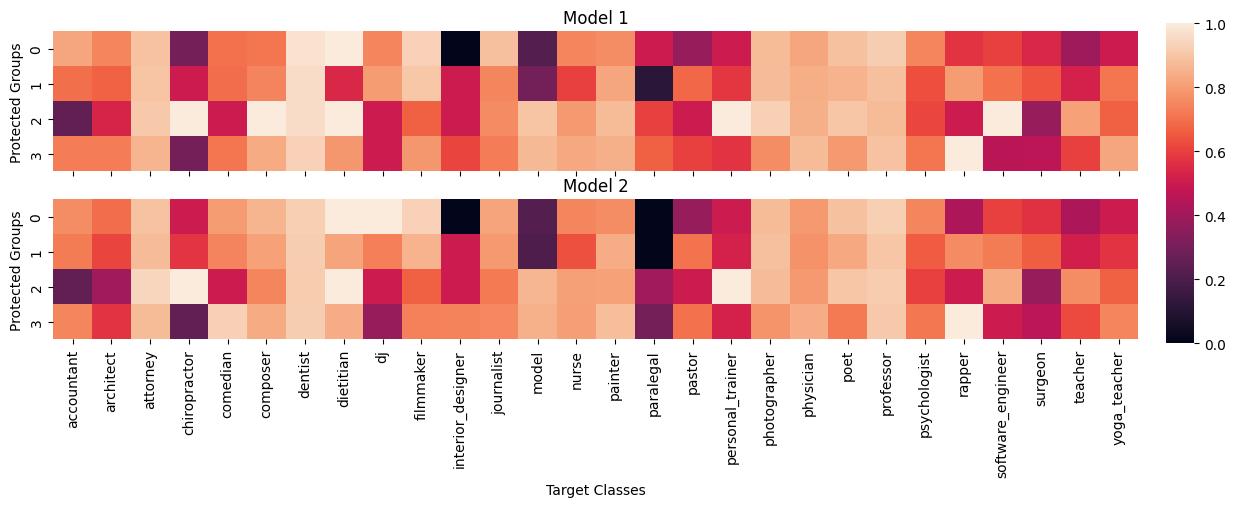

In [13]:
f, (a0, a1) = plt.subplots(2, 1, figsize=(14, 4), sharex=True)

cbar_ax = plt.axes([0.92, 0.1, 0.02, 0.8])

sns.heatmap(epoch_tprs["9.00"], ax=a0, vmin=0, vmax=1, cbar=False)
sns.heatmap(epoch_tprs["5.00"], ax=a1, vmin=0, vmax=1, cbar_ax=cbar_ax)

a1.set_xlabel("Target Classes")
a0.set_ylabel("Protected Groups")
a1.set_ylabel("Protected Groups")

a0.set_title("Model 1")
a1.set_title("Model 2")

a1.set_xticklabels(professions, rotation=90)

f.savefig("tpr_row_metrics_h.pdf", format="pdf", dpi=960, bbox_inches="tight") 

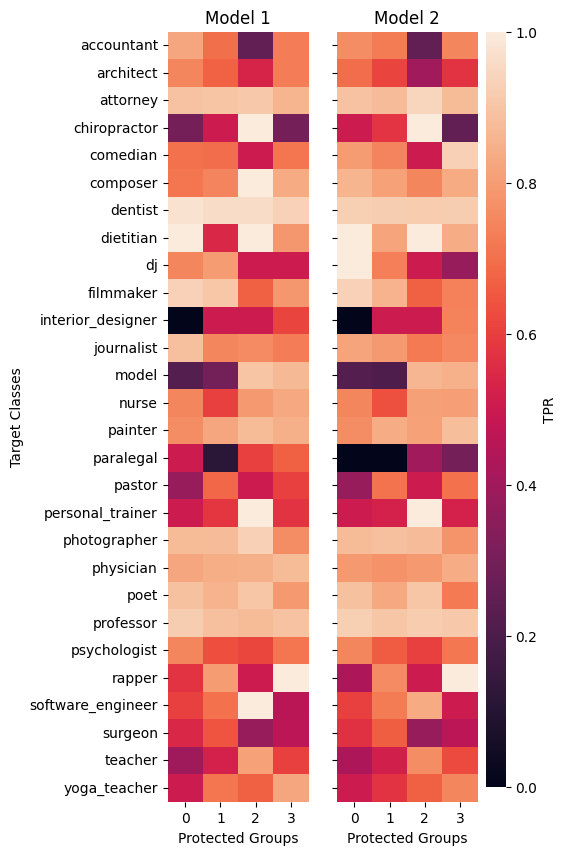

In [14]:
f, (a0, a1) = plt.subplots(1, 2, figsize=(4, 10), sharey=True)

cbar_ax = plt.axes([0.92, 0.125, 0.05, 0.755])

sns.heatmap(epoch_tprs["9.00"].T, ax=a0, vmin=0, vmax=1, cbar=False)
sns.heatmap(epoch_tprs["5.00"].T, ax=a1, vmin=0, vmax=1, cbar_ax=cbar_ax, cbar_kws={"label":"TPR"})

a0.set_ylabel("Target Classes")
a0.set_xlabel("Protected Groups")
a1.set_xlabel("Protected Groups")

a0.set_title("Model 1")
a1.set_title("Model 2")

a0.set_yticklabels(professions, rotation=0)


f.savefig("tpr_row_metrics_v.pdf", format="pdf", dpi=960, bbox_inches="tight") 

In [15]:
professions2id = {j:i for i,j in enumerate(professions)}
# selected_professions = ["dietitian", "dj", "nurse", "paralegal", "professor", "software_engineer", "surgeon"]
selected_professions = ["dietitian", "dj", "nurse", "paralegal", "professor","surgeon"]
selected_Professions = ["Dietitian", "DJ", "Nurse", "Paralegal", "Professor","Surgeon"]
selected_profession_id = np.array([professions2id[i] for i in selected_professions])


In [16]:
import matplotlib.ticker as ticker

In [17]:
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [0, ypos],transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

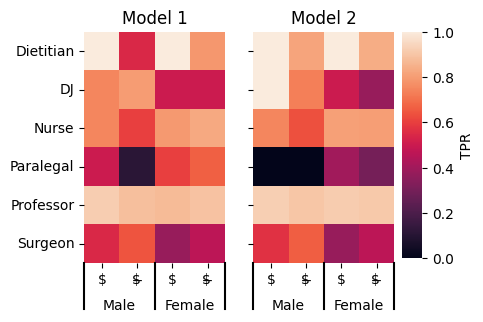

In [18]:
f, (a0, a1) = plt.subplots(1, 2, figsize=(4, 3), sharey=True)

cbar_ax = plt.axes([0.92, 0.125, 0.05, 0.755])

sns.heatmap(epoch_tprs["9.00"].T[selected_profession_id], ax=a0, vmin=0, vmax=1, cbar=False)
sns.heatmap(epoch_tprs["5.00"].T[selected_profession_id], ax=a1, vmin=0, vmax=1, cbar_ax=cbar_ax, cbar_kws={"label":"TPR"})


# a0.set_xlabel("Male   Female")
# a1.set_xlabel("Male   Female")

a0.set_title("Model 1")
a1.set_title("Model 2")

a0.set_yticklabels(selected_Professions, rotation=0)
a0.set_ylabel("")

a0.set_xticklabels(["$", "$\u0336", "$", "$\u0336"], rotation=0)
a1.set_xticklabels(["$", "$\u0336", "$", "$\u0336"], rotation=0)

# label_group_bar_table(ax=a1)
add_line(a1, 0, -0.2)
add_line(a1, 1, -0.2)
add_line(a1, 0.5, -0.2)

add_line(a0, 0, -0.2)
add_line(a0, 1, -0.2)
add_line(a0, 0.5, -0.2)

a0.text(0.25, -0.2, "Male", ha='center', transform=a0.transAxes)
a0.text(0.75, -0.2, "Female", ha='center', transform=a0.transAxes)

a1.text(0.25, -0.2, "Male", ha='center', transform=a1.transAxes)
a1.text(0.75, -0.2, "Female", ha='center', transform=a1.transAxes)

f.savefig("subset_tpr_row_metrics_v.pdf", format="pdf", dpi=960, bbox_inches="tight") 

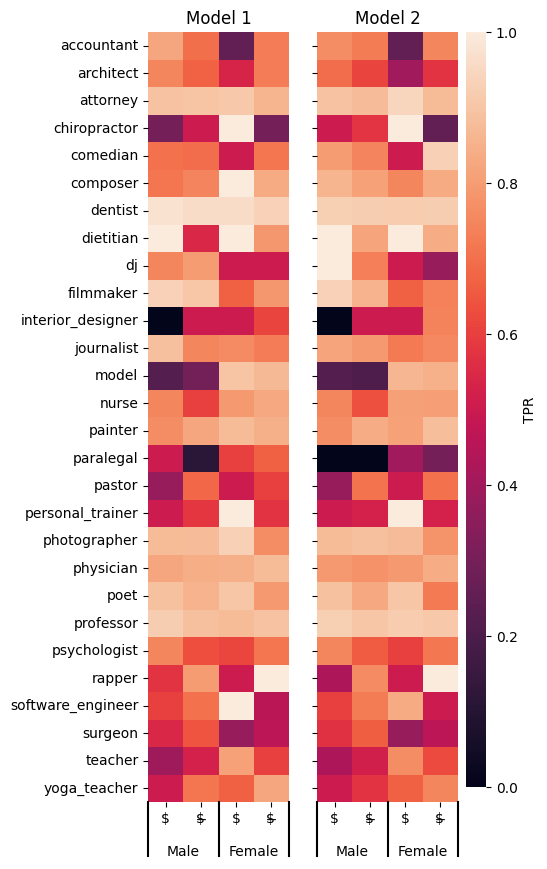

In [19]:
f, (a0, a1) = plt.subplots(1, 2, figsize=(4, 10), sharey=True)

cbar_ax = plt.axes([0.92, 0.125, 0.05, 0.755])

sns.heatmap(epoch_tprs["9.00"].T, ax=a0, vmin=0, vmax=1, cbar=False)
sns.heatmap(epoch_tprs["5.00"].T, ax=a1, vmin=0, vmax=1, cbar_ax=cbar_ax, cbar_kws={"label":"TPR"})

# a0.set_ylabel("Target Classes")
# a0.set_xlabel("Protected Groups")
# a1.set_xlabel("Protected Groups")

a0.set_title("Model 1")
a1.set_title("Model 2")

a0.set_yticklabels(professions, rotation=0)
a0.set_ylabel("")

a0.set_xticklabels(["$", "$\u0336", "$", "$\u0336"], rotation=0)
a1.set_xticklabels(["$", "$\u0336", "$", "$\u0336"], rotation=0)

add_line(a1, 0, -0.07)
add_line(a1, 1, -0.07)
add_line(a1, 0.5, -0.07)

add_line(a0, 0, -0.07)
add_line(a0, 1, -0.07)
add_line(a0, 0.5, -0.07)

a0.text(0.25, -0.07, "Male", ha='center', transform=a0.transAxes)
a0.text(0.75, -0.07, "Female", ha='center', transform=a0.transAxes)

a1.text(0.25, -0.07, "Male", ha='center', transform=a1.transAxes)
a1.text(0.75, -0.07, "Female", ha='center', transform=a1.transAxes)

f.savefig("annotated_tpr_row_metrics_v.pdf", format="pdf", dpi=960, bbox_inches="tight") 